## **RagamBatik - Klasifikasi Gambar Batik**

# Import Library

In [ ]:
# Import library
import os
import random
import shutil
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Data Loading

In [ ]:
from google.colab import files

# Download Dataset
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d nadyams/indonesia-batik-dataset
!unzip -q indonesia-batik-dataset.zip -d indonesia-batik-dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/nadyams/indonesia-batik-dataset
License(s): DbCL-1.0
 69% 122M/177M [00:00<00:00, 1.28GB/s]
100% 177M/177M [00:00<00:00, 1.09GB/s]


# Data Preprocessing

Kelas `Madura_Gentongan` dihapus dari dataset karena hanya memiliki **8 gambar**, jumlah yang terlalu sedikit dibandingkan kelas lain. Hal ini dilakukan untuk mencegah ketidakseimbangan ekstrem yang dapat memengaruhi kinerja model.

In [ ]:
# Hapus kelas yang tidak diinginkan
original_dataset_dir = '/content/indonesia-batik-dataset'

folder_to_remove = os.path.join(original_dataset_dir, 'Madura_Gentongan')
if os.path.exists(folder_to_remove):
    shutil.rmtree(folder_to_remove)
    print("Kelas 'Madura_Gentongan' berhasil dihapus dari dataset.")
else:
    print("Folder 'Madura_Gentongan' tidak ditemukan.")

Kelas 'Madura_Gentongan' berhasil dihapus dari dataset.


In [ ]:
# Split dataset ke train/val/test
original_dataset_dir = '/content/indonesia-batik-dataset'
base_dir = '/content/batik-dataset-split'
split_ratio = (0.7, 0.15, 0.15)  # train, val, test

for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)

classes = [cls for cls in os.listdir(original_dataset_dir) if os.path.isdir(os.path.join(original_dataset_dir, cls))]

for cls in tqdm(classes, desc="Membagi dataset"):
    src_path = os.path.join(original_dataset_dir, cls)
    files = os.listdir(src_path)
    random.shuffle(files)

    n_total = len(files)
    n_train = int(n_total * split_ratio[0])
    n_val = int(n_total * split_ratio[1])

    splits = {
        'train': files[:n_train],
        'val': files[n_train:n_train + n_val],
        'test': files[n_train + n_val:]
    }

    for split in ['train', 'val', 'test']:
        dst_dir = os.path.join(base_dir, split, cls)
        os.makedirs(dst_dir, exist_ok=True)
        for fname in splits[split]:
            shutil.copy(os.path.join(src_path, fname), os.path.join(dst_dir, fname))

print("Dataset berhasil dipisah ke dalam train/val/test.")

Membagi dataset: 100%|██████████| 23/23 [00:00<00:00, 30.15it/s]

Dataset berhasil dipisah ke dalam train/val/test.


In [ ]:
# Parameter
img_size = (224, 224)
batch_size = 32

# Augmentasi Gambar untuk train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Hitung class_weight
labels = train_generator.classes
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weight_dict = dict(enumerate(class_weights_array))

print("Class weights:", class_weight_dict)

Found 1532 images belonging to 23 classes.
Found 324 images belonging to 23 classes.
Found 340 images belonging to 23 classes.
Class weights: {0: np.float64(2.37888198757764), 1: np.float64(2.2202898550724637), 2: np.float64(2.37888198757764), 3: np.float64(0.7836317135549872), 4: np.float64(1.9031055900621119), 5: np.float64(0.2552057304680993), 6: np.float64(2.37888198757764), 7: np.float64(0.6343685300207039), 8: np.float64(2.37888198757764), 9: np.float64(2.466988727858293), 10: np.float64(2.37888198757764), 11: np.float64(2.37888198757764), 12: np.float64(2.37888198757764), 13: np.float64(2.2202898550724637), 14: np.float64(2.37888198757764), 15: np.float64(0.9515527950310559), 16: np.float64(0.59472049689441), 17: np.float64(0.4269788182831661), 18: np.float64(2.37888198757764), 19: np.float64(2.37888198757764), 20: np.float64(2.37888198757764), 21: np.float64(0.2632754768860629), 22: np.float64(1.1101449275362318)}


# Modelling

In [ ]:
# Build Model dengan Fine-tuning MobileNetV2
base_model = MobileNetV2(include_top=False, input_shape=img_size + (3,), weights='imagenet')
base_model.trainable = True  # unfreeze semua layer untuk fine-tuning

# Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.4)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,643,415 (10.08 MB)

 Trainable params: 2,606,743 (9.94 MB)

 Non-trainable params: 36,672 (143.25 KB)

In [ ]:
# Callbacks
checkpoint_path = 'best_batik_model.h5'
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, verbose=1)
]

In [ ]:
# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=70,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0563 - loss: 4.7189
Epoch 1: val_accuracy improved from -inf to 0.07716, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.0564 - loss: 4.7144 - val_accuracy: 0.0772 - val_loss: 3.8015 - learning_rate: 1.0000e-04
Epoch 2/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.0610 - loss: 4.1493
Epoch 2: val_accuracy improved from 0.07716 to 0.13580, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 583ms/step - accuracy: 0.0611 - loss: 4.1477 - val_accuracy: 0.1358 - val_loss: 3.6177 - learning_rate: 1.0000e-04
Epoch 3/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.0857 - loss: 3.8229
Epoch 3: val_accuracy improved from 0.13580 to 0.14815, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 572ms/step - accuracy: 0.0856 - loss: 3.8240 - val_accuracy: 0.1481 - val_loss: 3.4430 - learning_rate: 1.0000e-04
Epoch 4/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.1019 - loss: 3.8786
Epoch 4: val_accuracy improved from 0.14815 to 0.22840, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 578ms/step - accuracy: 0.1022 - loss: 3.8765 - val_accuracy: 0.2284 - val_loss: 3.2349 - learning_rate: 1.0000e-04
Epoch 5/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.1624 - loss: 3.6241
Epoch 5: val_accuracy improved from 0.22840 to 0.32407, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 568ms/step - accuracy: 0.1623 - loss: 3.6242 - val_accuracy: 0.3241 - val_loss: 3.0282 - learning_rate: 1.0000e-04
Epoch 6/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.1995 - loss: 3.5740
Epoch 6: val_accuracy improved from 0.32407 to 0.42593, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 563ms/step - accuracy: 0.1994 - loss: 3.5727 - val_accuracy: 0.4259 - val_loss: 2.8548 - learning_rate: 1.0000e-04
Epoch 7/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.2135 - loss: 3.2907
Epoch 7: val_accuracy improved from 0.42593 to 0.50309, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 564ms/step - accuracy: 0.2138 - loss: 3.2920 - val_accuracy: 0.5031 - val_loss: 2.6873 - learning_rate: 1.0000e-04
Epoch 8/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.2557 - loss: 3.2496
Epoch 8: val_accuracy improved from 0.50309 to 0.52469, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 602ms/step - accuracy: 0.2558 - loss: 3.2488 - val_accuracy: 0.5247 - val_loss: 2.5828 - learning_rate: 1.0000e-04
Epoch 9/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.3085 - loss: 2.9384
Epoch 9: val_accuracy improved from 0.52469 to 0.55864, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 575ms/step - accuracy: 0.3085 - loss: 2.9410 - val_accuracy: 0.5586 - val_loss: 2.4986 - learning_rate: 1.0000e-04
Epoch 10/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.3190 - loss: 2.8607
Epoch 10: val_accuracy improved from 0.55864 to 0.57407, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 564ms/step - accuracy: 0.3193 - loss: 2.8625 - val_accuracy: 0.5741 - val_loss: 2.3848 - learning_rate: 1.0000e-04
Epoch 11/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.3863 - loss: 2.9058
Epoch 11: val_accuracy improved from 0.57407 to 0.61420, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 562ms/step - accuracy: 0.3863 - loss: 2.9045 - val_accuracy: 0.6142 - val_loss: 2.2806 - learning_rate: 1.0000e-04
Epoch 12/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.4093 - loss: 2.6634
Epoch 12: val_accuracy improved from 0.61420 to 0.68210, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 574ms/step - accuracy: 0.4096 - loss: 2.6640 - val_accuracy: 0.6821 - val_loss: 2.1562 - learning_rate: 1.0000e-04
Epoch 13/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.4448 - loss: 2.5925
Epoch 13: val_accuracy improved from 0.68210 to 0.68827, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 565ms/step - accuracy: 0.4450 - loss: 2.5913 - val_accuracy: 0.6883 - val_loss: 2.0469 - learning_rate: 1.0000e-04
Epoch 14/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.4632 - loss: 2.5028
Epoch 14: val_accuracy improved from 0.68827 to 0.69136, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 563ms/step - accuracy: 0.4634 - loss: 2.5018 - val_accuracy: 0.6914 - val_loss: 1.9834 - learning_rate: 1.0000e-04
Epoch 15/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.5166 - loss: 2.3308
Epoch 15: val_accuracy did not improve from 0.69136
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 552ms/step - accuracy: 0.5166 - loss: 2.3296 - val_accuracy: 0.6914 - val_loss: 1.8886 - learning_rate: 1.0000e-04
Epoch 16/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.5258 - loss: 2.2428
Epoch 16: val_accuracy improved from 0.69136 to 0.74383, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 562ms/step - accuracy: 0.5258 - loss: 2.2421 - val_accuracy: 0.7438 - val_loss: 1.7780 - learning_rate: 1.0000e-04
Epoch 17/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.5541 - loss: 2.0605
Epoch 17: val_accuracy improved from 0.74383 to 0.75617, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 568ms/step - accuracy: 0.5544 - loss: 2.0608 - val_accuracy: 0.7562 - val_loss: 1.6964 - learning_rate: 1.0000e-04
Epoch 18/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.5810 - loss: 2.0445
Epoch 18: val_accuracy improved from 0.75617 to 0.76235, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 563ms/step - accuracy: 0.5812 - loss: 2.0437 - val_accuracy: 0.7623 - val_loss: 1.6302 - learning_rate: 1.0000e-04
Epoch 19/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.5930 - loss: 2.0039
Epoch 19: val_accuracy improved from 0.76235 to 0.76852, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 567ms/step - accuracy: 0.5933 - loss: 2.0019 - val_accuracy: 0.7685 - val_loss: 1.5667 - learning_rate: 1.0000e-04
Epoch 20/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.6270 - loss: 1.8947
Epoch 20: val_accuracy improved from 0.76852 to 0.77778, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 565ms/step - accuracy: 0.6272 - loss: 1.8935 - val_accuracy: 0.7778 - val_loss: 1.5166 - learning_rate: 1.0000e-04
Epoch 21/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.6948 - loss: 1.7071
Epoch 21: val_accuracy improved from 0.77778 to 0.78395, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 575ms/step - accuracy: 0.6941 - loss: 1.7077 - val_accuracy: 0.7840 - val_loss: 1.4672 - learning_rate: 1.0000e-04
Epoch 22/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.6776 - loss: 1.6385
Epoch 22: val_accuracy improved from 0.78395 to 0.80247, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 567ms/step - accuracy: 0.6778 - loss: 1.6384 - val_accuracy: 0.8025 - val_loss: 1.4009 - learning_rate: 1.0000e-04
Epoch 23/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.7140 - loss: 1.5695
Epoch 23: val_accuracy improved from 0.80247 to 0.80556, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 564ms/step - accuracy: 0.7139 - loss: 1.5686 - val_accuracy: 0.8056 - val_loss: 1.3791 - learning_rate: 1.0000e-04
Epoch 24/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.7217 - loss: 1.4764
Epoch 24: val_accuracy improved from 0.80556 to 0.81173, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 560ms/step - accuracy: 0.7218 - loss: 1.4772 - val_accuracy: 0.8117 - val_loss: 1.3259 - learning_rate: 1.0000e-04
Epoch 25/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.7078 - loss: 1.5287
Epoch 25: val_accuracy improved from 0.81173 to 0.81790, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 565ms/step - accuracy: 0.7080 - loss: 1.5280 - val_accuracy: 0.8179 - val_loss: 1.2972 - learning_rate: 1.0000e-04
Epoch 26/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.7657 - loss: 1.3649
Epoch 26: val_accuracy improved from 0.81790 to 0.82407, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 565ms/step - accuracy: 0.7653 - loss: 1.3652 - val_accuracy: 0.8241 - val_loss: 1.2753 - learning_rate: 1.0000e-04
Epoch 27/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.7623 - loss: 1.3573
Epoch 27: val_accuracy did not improve from 0.82407
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 548ms/step - accuracy: 0.7624 - loss: 1.3574 - val_accuracy: 0.8241 - val_loss: 1.2588 - learning_rate: 1.0000e-04
Epoch 28/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.7898 - loss: 1.3134
Epoch 28: val_accuracy improved from 0.82407 to 0.84259, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 560ms/step - accuracy: 0.7896 - loss: 1.3141 - val_accuracy: 0.8426 - val_loss: 1.2327 - learning_rate: 1.0000e-04
Epoch 29/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.7912 - loss: 1.2500
Epoch 29: val_accuracy improved from 0.84259 to 0.84568, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 571ms/step - accuracy: 0.7911 - loss: 1.2502 - val_accuracy: 0.8457 - val_loss: 1.2105 - learning_rate: 1.0000e-04
Epoch 30/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.8031 - loss: 1.2297
Epoch 30: val_accuracy did not improve from 0.84568
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 552ms/step - accuracy: 0.8031 - loss: 1.2297 - val_accuracy: 0.8457 - val_loss: 1.2405 - learning_rate: 1.0000e-04
Epoch 31/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.8111 - loss: 1.2100
Epoch 31: val_accuracy improved from 0.84568 to 0.84877, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 588ms/step - accuracy: 0.8113 - loss: 1.2098 - val_accuracy: 0.8488 - val_loss: 1.2083 - learning_rate: 1.0000e-04
Epoch 32/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.8124 - loss: 1.1657
Epoch 32: val_accuracy did not improve from 0.84877
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 547ms/step - accuracy: 0.8127 - loss: 1.1654 - val_accuracy: 0.8457 - val_loss: 1.1809 - learning_rate: 1.0000e-04
Epoch 33/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.8120 - loss: 1.2215
Epoch 33: val_accuracy improved from 0.84877 to 0.85185, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 566ms/step - accuracy: 0.8124 - loss: 1.2214 - val_accuracy: 0.8519 - val_loss: 1.1773 - learning_rate: 1.0000e-04
Epoch 34/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.8529 - loss: 1.1116
Epoch 34: val_accuracy did not improve from 0.85185
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 553ms/step - accuracy: 0.8527 - loss: 1.1119 - val_accuracy: 0.8364 - val_loss: 1.2570 - learning_rate: 1.0000e-04
Epoch 35/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.8621 - loss: 1.0826
Epoch 35: val_accuracy improved from 0.85185 to 0.85802, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 573ms/step - accuracy: 0.8620 - loss: 1.0825 - val_accuracy: 0.8580 - val_loss: 1.2429 - learning_rate: 1.0000e-04
Epoch 36/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.8523 - loss: 1.0651
Epoch 36: val_accuracy improved from 0.85802 to 0.86420, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 561ms/step - accuracy: 0.8526 - loss: 1.0650 - val_accuracy: 0.8642 - val_loss: 1.1960 - learning_rate: 1.0000e-04
Epoch 37/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.8408 - loss: 1.0901
Epoch 37: val_accuracy did not improve from 0.86420

Epoch 37: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 558ms/step - accuracy: 0.8409 - loss: 1.0903 - val_accuracy: 0.8395 - val_loss: 1.2228 - learning_rate: 1.0000e-04
Epoch 38/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.8722 - loss: 0.9866
Epoch 38: val_accuracy did not improve from 0.86420
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 546ms/step - accuracy: 0.8725 - loss: 0.9867 - val_accuracy: 0.8488 - val_loss: 1.2108 - learning_rate: 3.0000e-05
Epoch 39/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.8887 - loss: 0.9912
Epoch 39: val_accuracy did not improve from 0.86420
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 550ms/step - accuracy: 0.8883 - los

48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 566ms/step - accuracy: 0.9008 - loss: 0.9744 - val_accuracy: 0.8704 - val_loss: 1.1428 - learning_rate: 3.0000e-05
Epoch 46/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.8966 - loss: 0.9239
Epoch 46: val_accuracy did not improve from 0.87037
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 550ms/step - accuracy: 0.8969 - loss: 0.9243 - val_accuracy: 0.8673 - val_loss: 1.1383 - learning_rate: 3.0000e-05
Epoch 47/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.8675 - loss: 0.9493
Epoch 47: val_accuracy improved from 0.87037 to 0.87346, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 554ms/step - accuracy: 0.8678 - loss: 0.9492 - val_accuracy: 0.8735 - val_loss: 1.1359 - learning_rate: 3.0000e-05
Epoch 48/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.8777 - loss: 0.9642
Epoch 48: val_accuracy did not improve from 0.87346
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 541ms/step - accuracy: 0.8779 - loss: 0.9638 - val_accuracy: 0.8735 - val_loss: 1.1406 - learning_rate: 3.0000e-05
Epoch 49/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.9054 - loss: 0.9167
Epoch 49: val_accuracy did not improve from 0.87346
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 544ms/step - accuracy: 0.9055 - loss: 0.9171 - val_accuracy: 0.8704 - val_loss: 1.1569 - learning_rate: 3.0000e-05
Epoch 50/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.9242 - loss: 0.8757
Epoch 50: val_accuracy did not improve from 0.87346
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 547ms/step - accuracy: 0.9241 - loss: 0.8762 - val_accuracy: 0.8642 - val_loss: 1.1616 - learning_rate: 3.0000e-05


Epoch 51: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 567ms/step - accuracy: 0.9041 - loss: 0.9451 - val_accuracy: 0.8765 - val_loss: 1.1504 - learning_rate: 3.0000e-05
Epoch 52/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.8987 - loss: 0.9207
Epoch 52: val_accuracy improved from 0.87654 to 0.87963, saving model to best_batik_model.h5


48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 569ms/step - accuracy: 0.8988 - loss: 0.9205 - val_accuracy: 0.8796 - val_loss: 1.1479 - learning_rate: 9.0000e-06
Epoch 53/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.9127 - loss: 0.8746
Epoch 53: val_accuracy did not improve from 0.87963
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 551ms/step - accuracy: 0.9126 - loss: 0.8751 - val_accuracy: 0.8735 - val_loss: 1.1471 - learning_rate: 9.0000e-06
Epoch 54/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.8970 - loss: 0.9189
Epoch 54: val_accuracy did not improve from 0.87963
48/48 ━━━━━━━━━━━━━━━━━━━━ 28s 581ms/step - accuracy: 0.8971 - loss: 0.9189 - val_accuracy: 0.8673 - val_loss: 1.1474 - learning_rate: 9.0000e-06
Epoch 55/70
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.9084 - loss: 0.9611
Epoch 55: val_accuracy did not improve from 0.87963

Epoch 55: ReduceLROnPlateau reducing learning rate to 2.6999998226528985e-06.
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 546ms/step - accuracy: 0.9085 - los

In [ ]:
# Evaluasi di test set
model.load_weights(checkpoint_path)
test_loss, test_acc = model.evaluate(test_generator)
print(f"Akurasi di test set: {test_acc:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 994ms/step - accuracy: 0.8896 - loss: 1.2945
Akurasi di test set: 0.8882


In [ ]:
# Load Model dari Checkpoint Terbaik
model.load_weights('best_batik_model.h5')
print("Model terbaik berhasil dimuat dari checkpoint.")

# Compile Ulang Model dengan Learning Rate Kecil
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # lebih kecil agar fine-tuning halus
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Model dikompilasi ulang dengan learning rate lebih kecil (1e-5).")

Model terbaik berhasil dimuat dari checkpoint.
Model dikompilasi ulang dengan learning rate lebih kecil (1e-5).


In [ ]:
# Fine-Tuning Lanjutan
fine_tune_epochs = 30
initial_epoch = 70

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=initial_epoch + fine_tune_epochs,
    initial_epoch=initial_epoch,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

print("Fine-tuning lanjutan selesai.")

Epoch 71/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 964ms/step - accuracy: 0.9113 - loss: 0.9266
Epoch 71: val_accuracy did not improve from 0.87963
48/48 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9111 - loss: 0.9270 - val_accuracy: 0.8673 - val_loss: 1.1445 - learning_rate: 1.0000e-05
Epoch 72/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.9273 - loss: 0.9054
Epoch 72: val_accuracy did not improve from 0.87963
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 558ms/step - accuracy: 0.9271 - loss: 0.9061 - val_accuracy: 0.8704 - val_loss: 1.1527 - learning_rate: 1.0000e-05
Epoch 73/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.9097 - loss: 0.9083
Epoch 73: val_accuracy did not improve from 0.87963
48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 550ms/step - accuracy: 0.9097 - loss: 0.9085 - val_accuracy: 0.8704 - val_loss: 1.1514 - learning_rate: 1.0000e-05
Epoch 74/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - accuracy: 0.9108 - loss: 0.9239
Epoch 74: val_accuracy did not improve from 0.87963
48/4

# Evaluation

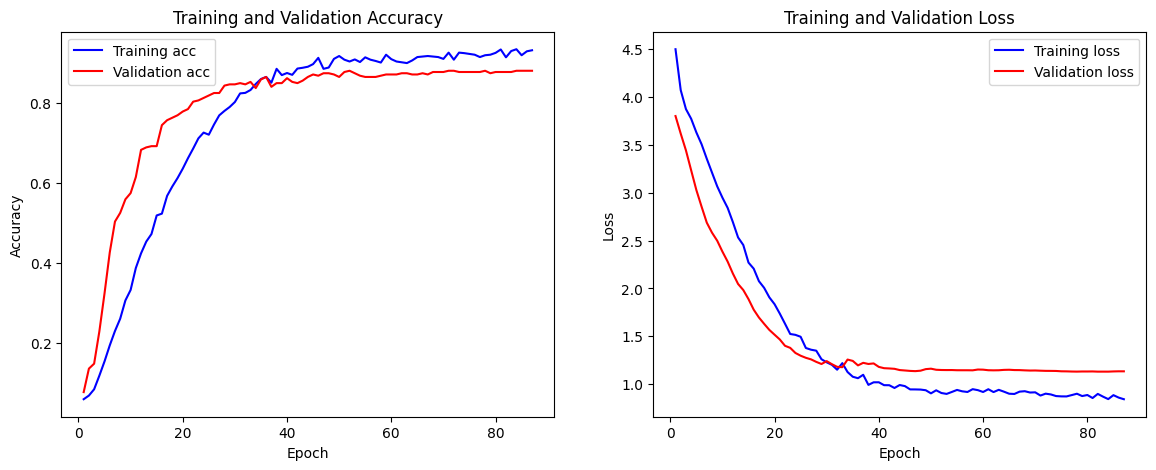

In [ ]:
# Fungsi untuk Gabung Plot Training Awal + Fine-Tuning
def plot_training(history1, history2=None):
    acc = history1.history['accuracy']
    val_acc = history1.history['val_accuracy']
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']

    if history2:
        acc += history2.history['accuracy']
        val_acc += history2.history['val_accuracy']
        loss += history2.history['loss']
        val_loss += history2.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training(history, history_finetune)

In [ ]:
# Evaluasi di test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Akurasi di test set: {test_acc:.4f}")
print(f"Loss di test set: {test_loss:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - accuracy: 0.8907 - loss: 1.2911
Akurasi di test set: 0.8882
Loss di test set: 1.2266


11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 404ms/step


<Figure size 1400x1000 with 0 Axes>

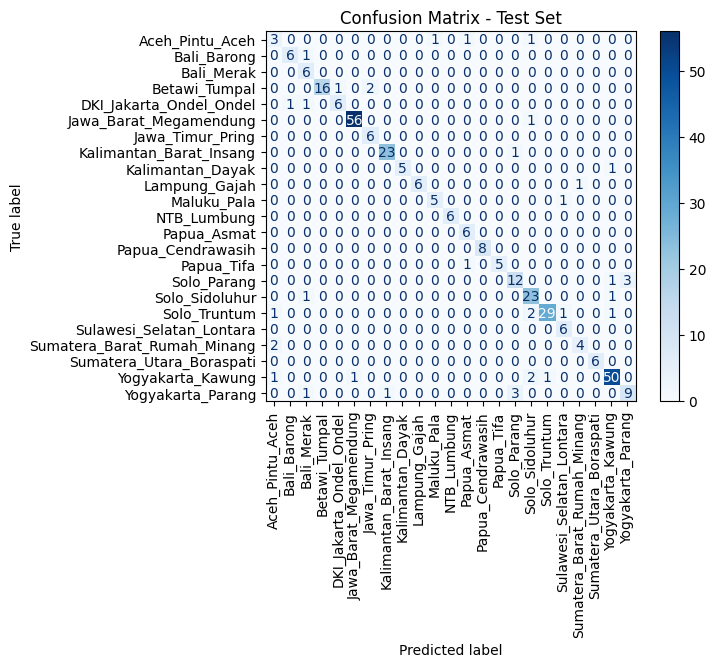

In [ ]:
# Confusion Matrix

# Prediksi kelas
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(14, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90, cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Test Set")
plt.show()

# Inference

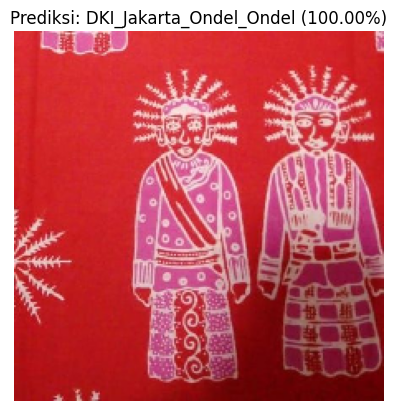

('DKI_Jakarta_Ondel_Ondel', np.float32(1.0))

In [ ]:
# Fungsi prediksi
def predict_image(img_path, model, class_indices, target_size=(224, 224)):
    # Load & preprocess image
    if not os.path.exists(img_path):
        print(f"Error: File not found at {img_path}")
        return None, None

    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    prediction = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(prediction[0])
    class_labels = list(class_indices.keys())
    confidence = prediction[0][predicted_class]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {class_labels[predicted_class]} ({confidence:.2%})")
    plt.show()

    return class_labels[predicted_class], confidence

# Path Image
img_path = '/content/indonesia-batik-dataset/DKI_Jakarta_Ondel_Ondel/Ondel (26).jpg'

predict_image(img_path, model, test_generator.class_indices)

In [ ]:
# Mengambil prediksi dari model
Y_pred_all = model.predict(test_generator, verbose=1)
y_pred_all = np.argmax(Y_pred_all, axis=1)
confidences_all = np.max(Y_pred_all, axis=1)
y_true_all = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Mengumpulkan confidence untuk setiap kelas yang diprediksi dengan benar
average_confidences = {}

for i in range(len(y_true_all)):
    true_idx = y_true_all[i]
    pred_idx = y_pred_all[i]
    confidence = confidences_all[i]

    if true_idx == pred_idx:
        class_name = class_labels[true_idx]
        if class_name not in average_confidences:
            average_confidences[class_name] = []
        average_confidences[class_name].append(confidence)

# Menampilkan rata-rata confidence per kelas (untuk prediksi yang benar)
print("\nRata-rata Confidence Prediksi yang Benar per Kelas:")
for class_name in class_labels:
    confidences = average_confidences.get(class_name, [])
    if confidences:
        avg_conf = np.mean(confidences)
        print(f"- {class_name}: {avg_conf:.2%}")
    else:
        print(f"- {class_name}: (Tidak ada prediksi yang benar)")

# Rata-rata confidence keseluruhan (semua prediksi)
average_confidence_overall = np.mean(confidences_all)
print(f"\nRata-rata Confidence Keseluruhan (Semua Prediksi): {average_confidence_overall:.2%}")

# Rata-rata confidence hanya untuk prediksi yang benar
correct_indices = np.where(y_true_all == y_pred_all)[0]
if len(correct_indices) > 0:
    average_confidence_correct = np.mean(confidences_all[correct_indices])
    print(f"Rata-rata Confidence Hanya untuk Prediksi yang Benar: {average_confidence_correct:.2%}")
else:
    print("Tidak ada prediksi yang benar di test set.")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step

Rata-rata Confidence Prediksi yang Benar per Kelas:
- Aceh_Pintu_Aceh: 99.91%
- Bali_Barong: 100.00%
- Bali_Merak: 90.61%
- Betawi_Tumpal: 100.00%
- DKI_Jakarta_Ondel_Ondel: 99.99%
- Jawa_Barat_Megamendung: 98.95%
- Jawa_Timur_Pring: 99.56%
- Kalimantan_Barat_Insang: 98.36%
- Kalimantan_Dayak: 100.00%
- Lampung_Gajah: 96.46%
- Maluku_Pala: 94.67%
- NTB_Lumbung: 99.97%
- Papua_Asmat: 99.99%
- Papua_Cendrawasih: 99.46%
- Papua_Tifa: 98.79%
- Solo_Parang: 92.10%
- Solo_Sidoluhur: 96.37%
- Solo_Truntum: 95.49%
- Sulawesi_Selatan_Lontara: 77.88%
- Sumatera_Barat_Rumah_Minang: 99.96%
- Sumatera_Utara_Boraspati: 93.15%
- Yogyakarta_Kawung: 97.22%
- Yogyakarta_Parang: 85.62%

Rata-rata Confidence Keseluruhan (Semua Prediksi): 94.25%
Rata-rata Confidence Hanya untuk Prediksi yang Benar: 96.80%


# Save Model

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import tensorflowjs as tfjs

# Mengonversi model ke format TensorFlow.js
tfjs.converters.save_keras_model(model, 'model_tfjs')

failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
import shutil
from google.colab import files

shutil.make_archive('model_tfjs', 'zip', 'model_tfjs')

files.download('model_tfjs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>